## 特記事項

本コンペティションで提供されている[学習用データ](#学習用データ)は以下の著作物を加工して作成したものである.

- 提供元: [人文学オープンデータ共同利用センター](http://codh.rois.ac.jp/)
- 『日本古典籍くずし字データセット』（国文研ほか所蔵／CODH加工） doi:10.20676/00000340

ライセンスは以下

- [クリエイティブ・コモンズ 表示 - 継承 4.0 国際 ライセンス（CC BY-SA）](https://creativecommons.org/licenses/by-sa/4.0/)

# データのダウンロード

現在, 本コンペのデータのダウンロードはできない

In [27]:
# 参考: https://qiita.com/insilicomab/items/d757339d97b44feaff01
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=6fe72e686a7bbb6f8b3ea27df6c62a2e85b6431ced3d1c59d9abcb5c666ce55d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Download 100%.


In [ ]:
!signate download -c 1219


# ライブラリのインストール

In [10]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.9 MB/s eta 0:00:00


# ライブラリのインポート

In [11]:
import json
import math
import os
import shutil
import sys
from glob import glob

import timm
import torch
import torch.nn.utils as utils
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import KFold, train_test_split
from torch import Tensor, nn
from torch.nn import CTCLoss
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T

train_dir = './train'


# 学習用データの確認

In [ ]:
!unzip train.zip


In [ ]:
img_path = os.path.join(train_dir, '00000.jpg')
img = Image.open(img_path)
print('width, height: ', img.size)
print('mode:', img.mode)


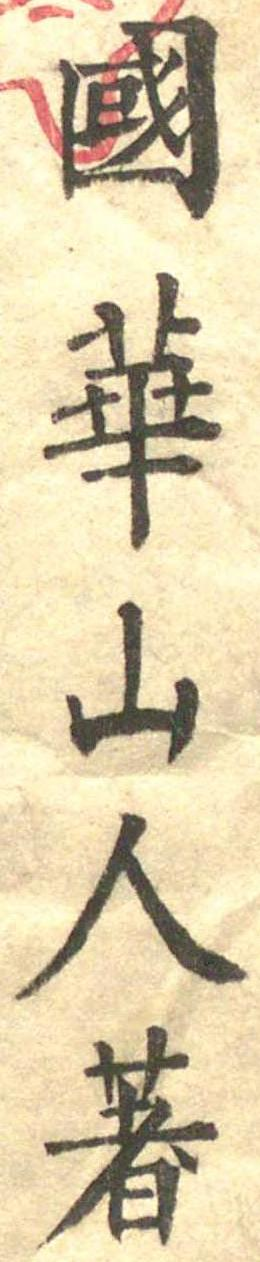

In [ ]:
img


In [ ]:
def describe(image_dir: str):
    count = 0
    height = 0
    width = 0
    max_height = 0
    max_width = 0
    max_aspect_ratio = 0
    for img_path in os.listdir(image_dir):
        if os.path.splitext(img_path)[-1] == '.jpg':
            img = Image.open(os.path.join(train_dir, img_path))
            count += 1
            width += img.size[0]
            height += img.size[1]
            max_width = max(img.size[0], max_width)
            max_height = max(img.size[1], max_height)
            max_aspect_ratio = max(img.size[1] / img.size[0], max_aspect_ratio)
    print('画像数: ', count)
    print('縦:', height / count)
    print('横:', width / count)
    print('縦の最大値:', max_height)
    print('横の最大値:', max_width)
    print('アスペクト比の最大値:', max_aspect_ratio)


In [ ]:
describe(train_dir)


画像数:  35567
縦: 2191.986166952512
横: 170.7284280372255
縦の最大値: 4486
横の最大値: 531
アスペクト比の最大値: 32.657534246575345


In [ ]:
annotation_path = os.path.join(train_dir, '00000.json')
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)


In [ ]:
ann


{'book_id': '000',
 'page_id': '00002',
 'text': '国華山人著',
 'labels': [{'label': '国', 'bbox': [59, 15, 219, 219]},
  {'label': '華', 'bbox': [42, 272, 221, 549]},
  {'label': '山', 'bbox': [66, 601, 198, 763]},
  {'label': '人', 'bbox': [15, 813, 245, 999]},
  {'label': '著', 'bbox': [39, 1025, 217, 1247]}]}

In [ ]:
def vis_annotation(img, ann, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)  # PILでフォントを定義
    draw = ImageDraw.Draw(img)
    for label in ann['labels']:
        draw.text(xy=(label['bbox'][0] - font_size,
                      int((label['bbox'][1] + label['bbox'][3]) / 2)),
                  text=label['label'],
                  font=font,
                  fill=(255, 0, 0))
        draw.line((label['bbox'][0], label['bbox'][1], label['bbox'][2],
                   label['bbox'][1]),
                  fill=(255, 0, 0),
                  width=1)
        draw.line((label['bbox'][2], label['bbox'][1], label['bbox'][2],
                   label['bbox'][3]),
                  fill=(255, 0, 0),
                  width=1)
        draw.line((label['bbox'][2], label['bbox'][3], label['bbox'][0],
                   label['bbox'][3]),
                  fill=(255, 0, 0),
                  width=1)
        draw.line((label['bbox'][0], label['bbox'][3], label['bbox'][0],
                   label['bbox'][1]),
                  fill=(255, 0, 0),
                  width=1)
    print(ann['text'])
    return img


国華山人著


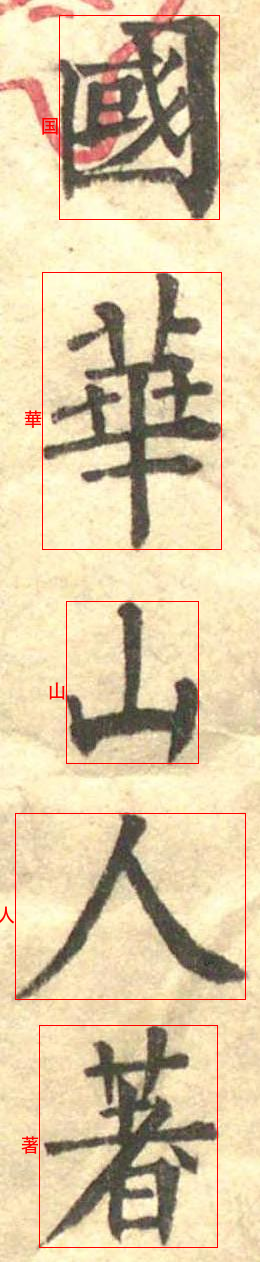

In [ ]:
font_path = './ヒラギノ角ゴシック W5.ttc'  # フォントファイルへのパス
font_size = 18  # フォントサイズの指定
img = vis_annotation(img, ann, font_path, font_size)
img


In [ ]:
# book_id_list を出力するよう改良
# max_len_text を出力するよう改良
def check_characters(img_dir: str):
    characters = {}
    book_id_list = set()
    max_len_text = 0
    for ann_path in os.listdir(img_dir):
        if os.path.splitext(ann_path)[-1] == '.json':
            with open(os.path.join(train_dir, ann_path),
                      encoding='utf-8') as f:
                ann = json.load(f)
            for character in ann['text']:
                if character not in characters:
                    characters[character] = 1
                else:
                    characters[character] += 1
                if not (ann['book_id'] in book_id_list):
                    book_id_list.add(ann['book_id'])
            max_len_text = max(max_len_text, len(ann['text']))
    print('文字種数:', len(characters))
    print('\n出現頻度Top10:')
    for d in sorted(characters.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(' ', d[0], d[1])
    print('\n出現頻度Worst10:')
    for d in sorted(characters.items(), key=lambda x: x[1])[:10]:
        print(' ', d[0], d[1])
    print('\nbook_id_list:')
    print(sorted(book_id_list))
    print(max_len_text)


In [ ]:
check_characters(train_dir)


文字種数: 3968

出現頻度Top10:
  の 27055
  に 25198
  し 24205
  て 19644
  を 17292
  と 15545
  か 15533
  り 15526
  は 15016
  な 14358

出現頻度Worst10:
  饕 1
  餮 1
  蟋 1
  蜴 1
  ビ 1
  鯵 1
  儉 1
  頷 1
  鰥 1
  仭 1

book_id_list:
['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029']
78


# 学習用データの前処理

In [ ]:
# make_data の引数 book_id_list を削除
def make_data(src_img_dir, dst_img_dir):
    print('\n' + src_img_dir)
    count = 0
    character_labels = set()
    for fname in os.listdir(src_img_dir):
        sname, ext = os.path.splitext(fname)
        if ext == '.json':
            with open(os.path.join(src_img_dir, fname)) as f:
                ann = json.load(f)
                # if ann['book_id'] in book_id_list:
                shutil.copy(os.path.join(src_img_dir, fname),
                            os.path.join(dst_img_dir, fname))
                shutil.copy(os.path.join(src_img_dir, sname + '.jpg'),
                            os.path.join(dst_img_dir, sname + '.jpg'))
                for w in ann['text']:
                    character_labels.add(w)
                count += 1
            if count % 1000 == 0:
                print('{} samples copied to {}'.format(count, dst_img_dir))
    index2character = {i + 1: s for i, s in enumerate(character_labels)}
    character2index = {v: k for k, v in index2character.items()}
    with open('./index2character.json', 'w', encoding='utf-8') as f:
        json.dump(index2character, f, ensure_ascii=False, indent=4)
    with open('./character2index.json', 'w', encoding='utf-8') as f:
        json.dump(character2index, f, ensure_ascii=False, indent=4)
    print('{} samples copied to {}'.format(count, dst_img_dir))


In [ ]:
dst_img_dir = './train_data'
os.makedirs(dst_img_dir, exist_ok=True)
# book_id_list=['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
make_data(train_dir, './train_data')


In [ ]:
describe(dst_img_dir)


画像数:  35567
縦: 2191.986166952512
横: 170.7284280372255
縦の最大値: 4486
横の最大値: 531
アスペクト比の最大値: 32.657534246575345


In [ ]:
check_characters(dst_img_dir)


文字種数: 3968

出現頻度Top10:
  の 27055
  に 25198
  し 24205
  て 19644
  を 17292
  と 15545
  か 15533
  り 15526
  は 15016
  な 14358

出現頻度Worst10:
  饕 1
  餮 1
  蟋 1
  蜴 1
  ビ 1
  鯵 1
  儉 1
  頷 1
  鰥 1
  仭 1

book_id_list:
['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029']
78


In [ ]:
class KuzushijiDataset(torch.utils.data.Dataset):  # type: ignore

    def __init__(self, root, character2index, transforms, on_memory=False):
        self.root = root
        self.character2index = character2index
        self.transforms = transforms
        self.on_memory = on_memory
        if on_memory:
            self.imgs = [
                Image.open(img_path)
                for img_path in sorted(glob(os.path.join(root, '*.jpg')))
            ]
            self.annotations = []
            for ann_path in sorted(glob(os.path.join(root, '*.json'))):
                with open(ann_path, encoding='utf-8') as f:
                    self.annotations.append(json.load(f))
        else:
            self.imgs = sorted(glob(os.path.join(root, '*.jpg')))
            self.annotations = sorted(glob(os.path.join(root, '*.json')))

    def __getitem__(self, idx):
        if self.on_memory:
            img = self.imgs[idx]
            ann = self.annotations[idx]
        else:
            img = Image.open(self.imgs[idx])
            with open(self.annotations[idx], encoding='utf-8') as f:
                ann = json.load(f)

        labels = torch.as_tensor(
            [self.character2index[character] for character in ann['text']],
            dtype=torch.int32)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, labels

    def __len__(self):
        return len(self.imgs)


## Data Augmentation

ImageNet の 平均, 分散で標準化を行う

In [ ]:
class Compose:

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)

        return image


class Align():

    def __init__(self, target_width, max_target_height):
        self.target_width = target_width
        self.max_target_height = max_target_height

    def __call__(self, image: Image.Image):
        w, h = image.size
        s = self.target_width / w
        target_height = int(s * h)
        image = image.resize((self.target_width, target_height))
        img = Image.new(mode='RGB',
                        size=(self.target_width, self.max_target_height),
                        color=(255, 255, 255))
        img.paste(im=image)
        return img


class RandomHorizontalFlip(T.RandomHorizontalFlip):

    def forward(self, image: Tensor) -> Tensor:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
        return image


class PILToTensor(nn.Module):

    def forward(self, image: Tensor) -> Tensor:
        image = F.pil_to_tensor(image)
        return image


class ConvertImageDtype(nn.Module):

    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(self, image: Tensor) -> Tensor:
        image = F.convert_image_dtype(image, self.dtype)
        return image


def get_transform(train, target_width, max_target_height):
    transforms = []
    transforms.append(Align(target_width, max_target_height))
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
    transforms.append(T.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225]))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)


In [ ]:
# on_memory=Trueにした場合, このセルを2回以上実行するとエラーになるので, 2回以上実行する際は事前に`kuzushiji_dataset`を削除(`del kuzushiji_dataset`)してください.
with open('./character2index.json', encoding='utf-8') as f:
    character2index = json.load(f)
target_width = 128
max_target_height = 3840
kuzushiji_dataset = KuzushijiDataset(
    './train_data', character2index,
    get_transform(train=True,
                  target_width=target_width,
                  max_target_height=max_target_height))


In [ ]:
with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
img, labels = kuzushiji_dataset[10]

print('image:')
print(' ', type(img), img.shape)
print('labels:')
print(' ', type(labels), labels.shape)
for l in labels:
    print(int(l), index2character[str(int(l))])


## final submit のため, 全てのデータで学習を行う

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


# データセットの読み込み
dataset = kuzushiji_dataset

# # データセットの分割
# train_ratio = 0.8  # 学習データの割合
# val_ratio = 0.1    # 検証データの割合
# test_ratio = 0.1   # テストデータの割合
# total_samples = len(dataset)

# # データセットを分割
# train_size = int(train_ratio * total_samples)
# val_size = int(val_ratio * total_samples)
# test_size = total_samples - train_size - val_size  # テストデータサイズは残りの部分

# # ランダムにデータを分割
# train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, total_samples - train_size])
# val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size])

# データローダーの作成
batch_size = 8
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)


# 機械学習モデルの構築

In [ ]:
class KuzushijiModel(torch.nn.Module):

    def __init__(self,
                 model_name,
                 num_classes,
                 input_length=80,
                 d_model=512,
                 pretrained=True):
        super(KuzushijiModel, self).__init__()
        self.backbone = timm.create_model(model_name=model_name,
                                          pretrained=pretrained)
        self.apool = torch.nn.AdaptiveAvgPool2d((input_length, 1))
        self.linear = torch.nn.Linear(self.backbone.num_features, d_model)

        self.last_linear = torch.nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = torch.relu(self.backbone.forward_features(x))
        x = self.apool(x)
        x = x.squeeze(3)
        x = x.permute(2, 0, 1)
        x = torch.relu(self.linear(x))
        x = self.last_linear(x)

        return x


In [ ]:
timm.list_models(pretrained=False)


['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

input_length: 画像を縦方向に何分割するか  
max_len_text = 78 であったため, input_length = 80 とする  
  
文字種数が 3968 であったため, 空欄を含めて num_classes = 3969  
  
計算リソースを考慮して, tf_efficientnetv2_s を採用する

In [ ]:
input_length = 80
num_classes = 3968 + 1
model = KuzushijiModel(model_name='tf_efficientnetv2_s',
                       num_classes=num_classes,
                       input_length=input_length)


# 学習

## 1epoch 学習を行う関数

In [ ]:
def train_one_epoch(model, optimizer, data_loader, ctc_loss, input_length, device, print_freq):
    model.train()

    size = len(data_loader)
    for i, (images, targets) in enumerate(data_loader):
        images = torch.stack(images).to(device)
        input_lengths = torch.full(size=(len(images),), fill_value=input_length, dtype=torch.long)
        max_target_length = 0
        target_lengths = []
        for t in targets:
            target_lengths.append(len(t))
            max_target_length = max(t.shape[0], max_target_length)
        target_lengths = torch.tensor(target_lengths)
        targets_filled = []
        for t in targets:
            targets_filled.append(torch.cat((t, torch.zeros(max_target_length - len(t), dtype=torch.int32))))
        targets_filled = torch.stack(targets_filled).to(device)
        y = model(images)
        log_softmax = y.log_softmax(2)
        optimizer.zero_grad()
        loss = ctc_loss(log_softmax, targets_filled, input_lengths, target_lengths)
        if (i + 1) % print_freq == 0:
            print('[{}/{}] Loss: {}'.format(i + 1, size, round(float(loss), 3)))
        if not math.isfinite(float(loss)):
            print(f"Loss is {float(loss)}, stopping training")
            print(float(loss))
            sys.exit(1)

        loss.backward()

        optimizer.step()
        lr_scheduler.step()


## 学習ループ

5-fold ensemble  
final submit のため, 全てのデータを学習に用いる

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')

# ハイパラ の設定
num_epochs = 5

# 5-foldクロスバリデーションのためのフォールド数
num_folds = 5

# データを5つのフォールドに分割
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# 5回のクロスバリデーションを実行
# datasetはデータセットへの参照に置き換える必要があります
for fold, (train_idx, val_idx) in enumerate(kf.split(kuzushiji_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # フォールドごとにモデルを初期化し、訓練
    model = KuzushijiModel(
        model_name='tf_efficientnetv2_s',
        num_classes=num_classes,
        input_length=input_length)  # YourModelClassはモデルのクラスに置き換える必要があります
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    ctc_loss = torch.nn.CTCLoss()
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        len(train_idx) * num_epochs)
    model.to(device)

    # フォールドごとのデータを設定
    train_data_fold = torch.utils.data.Subset(dataset, train_idx)
    val_data_fold = torch.utils.data.Subset(dataset, val_idx)

    # DataLoaderの作成
    train_loader = DataLoader(train_data_fold,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=collate_fn)
    val_loader = DataLoader(val_data_fold,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

    # エポックごとのトレーニング
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # 1エポックのトレーニングを実行
        train_one_epoch(model,
                        optimizer,
                        train_loader,
                        ctc_loss,
                        input_length,
                        device,
                        print_freq=10)

    torch.save(
        model.to('cpu').state_dict(), './model_fold_' + str(fold) + '.pth')

# # アンサンブルモデルの予測を計算
# def ensemble_predictions(models, data_loader):
#     predictions = []
#     for model in models:
#         model.eval()
#         model.to(device)
#         fold_predictions = []
#         with torch.no_grad():
#             for images, _ in data_loader:
#                 images = torch.stack(images).to(device)
#                 y = model(images)
#                 predictions.append(y)
#     return torch.stack(predictions).mean(dim=0)

# # テストデータ用のDataLoaderを作成
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# # アンサンブルモデルを使用してテストデータを予測
# ensemble_predictions = ensemble_predictions(ensemble_models, test_loader)


# 予測の後処理

同じ文字が連続する場合, 1 文字にまとめる

torch.Size([80, 1, 3969])
正解: いふとひ女郎めだいひぶんがあるがよふいはぬ
推論: いふとひ女らめだいひぶんがあるがよふいはぬ


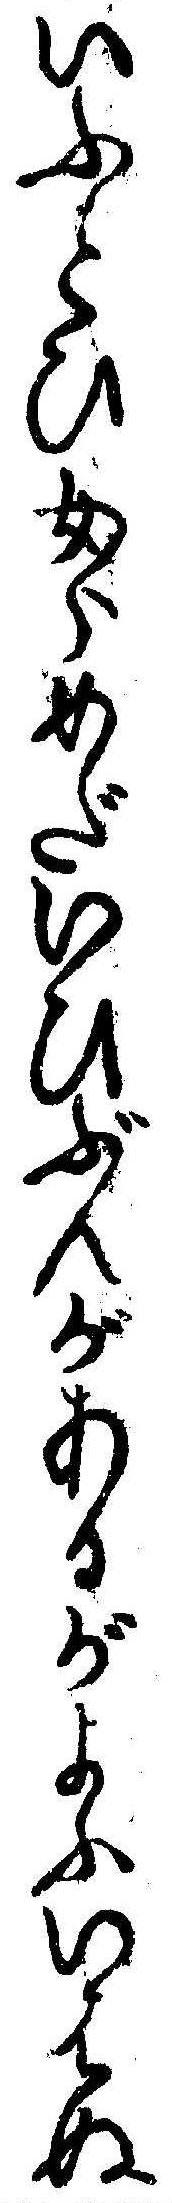

In [ ]:
sample_id = '13021'
# 予測
img_path = os.path.join(train_dir, '{}.jpg'.format(sample_id))
image = Image.open(img_path)
img = get_transform(train=False, target_width=target_width, max_target_height=max_target_height)(image)
img = img.unsqueeze(0) # type: ignore
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model(img.to(device)) # type: ignore
    print(prediction.size())
_, output_index = prediction.max(2)
pred = output_index.squeeze(1).cpu().detach().numpy()

with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
txt = ''
prev_p = 0
for p in pred:
    if p != 0 and p != prev_p:
        txt+=index2character[str(p)]
        prev_p = p

# 正解ラベル
annotation_path = os.path.join(train_dir, '{}.json'.format(sample_id))
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)
ans = ann['text']

print('正解: {}'.format(ans))
print('推論: {}'.format(txt))
image

# 精度の評価

In [ ]:
!unzip run_test.zip

Archive:  run_test.zip
  inflating: run_test/docker-compose.yml  
  inflating: run_test/Dockerfile     
  inflating: run_test/evaluate.py    
  inflating: run_test/make_submit.sh  
  inflating: run_test/make_val.py    
  inflating: run_test/run.py         
   creating: run_test/src/
  inflating: run_test/src/evaluator.py  
  inflating: run_test/src/generator.py  
  inflating: run_test/src/preprocessor.py  
  inflating: run_test/src/runner.py  
  inflating: run_test/src/validator.py  
   creating: run_test/submit/
   creating: run_test/submit/model/
 extracting: run_test/submit/model/init.txt  
   creating: run_test/submit/src/
  inflating: run_test/submit/src/predictor.py  


In [ ]:
!python ./run_test/make_val.py

In [ ]:
!python ./run_test/run.py  --exec-dir ./submit/src --input-data-path ./input.json --val-data-dir ./train

/content

Runtime: 35567 samples

35567it [1:09:51,  8.48it/s]
  0.11785744213691249 [s/sample]

Validation:
  Checking data... Done
  Checking samples... Done
  Checking dtype... Done
  Checking keys... Done

Preprocessing:
  saved the result to /content/results/predictions.json


In [ ]:
!python ./run_test/evaluate.py


Validation:
  Checking data... Done
  Checking samples... Done
  Checking dtype... Done
  Checking keys... Done

Evaluation:
  TP: 599504
  FP: 9661
  FN: 73015

Score: 0.9354942403899871

